# Unsupervised Learning Capstone
## Email Novelty Detection
###  Introduction

The purpose of this capstone is to identify the most unique emails based on text classification and Natural Language Processing using spaCy.  

### Data

The data used for this project is the Enron email corpus.  We will use this model and try to identify unique emails out of the data set.  Specifically, we look at the sent emails from each user.  This way, the texts can be labeled to be identified to unique emails.

You can download the data from here:  https://www.kaggle.com/wcukierski/enron-email-dataset/data

I didn't do that, and I ultimately did it the hard way by downloading the originals and traversing the path.  The data in the link from Kaggle is already formatted for you, which would've made this whole thing a lot easier, but you live and learn.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import re
import glob
import email
from nltk.corpus import stopwords
import spacy
import nltk

In [2]:
# Utility function to clean text.
def text_cleaner(text):  
    text = re.sub(r'-',' ',text)
    text = re.sub("\n", " ", text)
    text = re.sub("~.*", "", text)
    text = re.sub('[^A-Za-z .-]+', ' ', text)
    text = re.sub('HOU ECT', '', text)
    text = re.sub('\.', '', text)
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    text = re.sub("Get Your Private, Free E mail from MSN Hotmail at", "", text)    
    text = re.sub("Forwarded by", "", text)
    return text

In [3]:
# Here I am limiting this to 1000 emails.  NLP is extremely memory intensive and I could not run this on my computer without
# memory errors for the entire body of emails.

i = 0

directory = "C:\\Users\\kim\\Downloads\\enron_mail\\maildir"

fileList = [os.path.normcase(f)
                for f in os.listdir(directory)] 

stopWords = set(stopwords.words('english'))

records = []

for f in fileList:
    sent_emails = "C:\\Users\\kim\\Downloads\\enron_mail\\maildir\\{0}\\sent".format(f) 
    try:
    
        for f1 in os.listdir(sent_emails):
            if i == 1000:
                break
            f1 = "C:\\Users\\kim\\Downloads\\enron_mail\\maildir\\{0}\\sent\\{1}".format(f, f1) 
            my_file = open(f1, 'r')
            text = my_file.read()
            
            b = email.message_from_string(text)
            if b.is_multipart():
                for payload in b.get_payload():
                    # if payload.is_multipart(): ...
                    text = payload.get_payload()
            else:
                text = b.get_payload()
            text = text_cleaner(text)
            i += 1
            record = [f, text]
            records.append(record)
    except FileNotFoundError:
        continue

In [4]:
df = pd.DataFrame(records, columns=['user','text'])

In [5]:
df.head()

,user,text
0,allen-p,Phillip K Allen on PM Lucy Gonzalez stagecoac...
1,allen-p,Phillip K Allen on PM Enron admin FSDDataSvcc...
2,allen-p,Larry Just a note to touch base on the sagewoo...
3,allen-p,Ina I scheduled a meeting with Jean Mrha tomor...
4,allen-p,Phillip K Allen on AM Jeff Richter AM To Phil...


In [6]:
# Using SpaCy to turn each email into a SpaCy doc object and store it in a dataframe
# Once it's in a doc object format
nlp = spacy.load('en') 
df['doc'] = df['text'].apply(lambda x: nlp(x))
df['word_count'] = df['doc'].apply(lambda x: len(x))

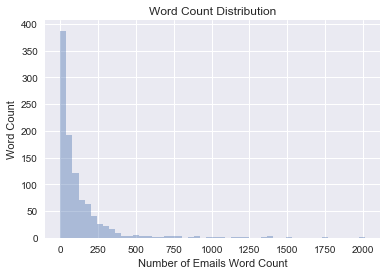

In [7]:
fig = sns.distplot(df.word_count, kde=False)
fig.set(xlabel='Number of Emails Word Count', ylabel='Word Count', title='Word Count Distribution');

Because emails with very small word counts skews the results, we will remove them from the data.

In [8]:
df = df[df['word_count']>=20]

In [9]:
df.describe()

,word_count
count,778.000000
mean,158.475578
std,218.183209
min,20.000000
25%,45.000000
50%,89.500000
75%,181.750000
max,2011.000000


In [10]:
all_documents = []

for index, row in df.iterrows():
    doc = row['doc']
    for index2, row2 in df.iterrows():
        doc2 = row2['doc']
        similarity = doc.similarity(doc2)
        if(row['user'] == row2['user'] and row['text'] == row2['text']):
            continue;
        else:
            all_documents.append([row['user'], row['text'], similarity, row2['user'], row2['text']])  

In [11]:
all_documents = pd.DataFrame(all_documents, columns=['user','text','similarity', 'user2', 'text2'])

In [12]:
all_documents.sort_values(by='similarity')

,user,text,similarity,user2,text2
171941,allen-p,Phillip K Allen on AM To Phillip K Allen ECT ...,0.140158,allen-p,Here is the buyout spreadsheet again with a sl...
187462,allen-p,Here is the buyout spreadsheet again with a sl...,0.140158,allen-p,Phillip K Allen on AM To Phillip K Allen ECT ...
158734,allen-p,Phillip K Allen on PM Parking Transportation ...,0.140953,allen-p,Here is the buyout spreadsheet again with a sl...
187445,allen-p,Here is the buyout spreadsheet again with a sl...,0.140953,allen-p,Phillip K Allen on PM Parking Transportation ...
233323,allen-p,Phillip K Allen on AM Susan J Mara ENRON PM T...,0.142737,allen-p,Here is the buyout spreadsheet again with a sl...
187540,allen-p,Here is the buyout spreadsheet again with a sl...,0.142737,allen-p,Phillip K Allen on AM Susan J Mara ENRON PM T...
187978,allen-p,Here is the buyout spreadsheet again with a sl...,0.147654,arnold-j,none From John J Lavorato ENRON enronXgate on ...
573609,arnold-j,none From John J Lavorato ENRON enronXgate on ...,0.147654,allen-p,Here is the buyout spreadsheet again with a sl...
187530,allen-p,Here is the buyout spreadsheet again with a sl...,0.147663,allen-p,Phillip K Allen on AM Robert Neustaedter ENRO...
225553,allen-p,Phillip K Allen on AM Robert Neustaedter ENRO...,0.147663,allen-p,Here is the buyout spreadsheet again with a sl...


The two texts below are the least similar.  This finds the most novel, unique emails in the body of emails compared to each other.

In [24]:
all_documents.iloc[171941]['text']

' Phillip K Allen on AM To Phillip K Allen ECT cc Subject Current Gas Desk List Hope this helps This is the current gas desk list that I have in my personal address book Call me with any questions Erika GROUP East Desk Basics Group name East Desk Group type Multi purpose Description Members Matthew B Fleming HOU EES James R Barker HOU EES Barend VanderHorst HOU EES Jay Blaine HOU EES Paul Tate HOU EES Alain Diza HOU EES Rhonda Smith HOU EES Christina Bangle HOU EES Sherry Pendegraft HOU EES Marde L Driscoll HOU EES Daniel Salinas HOU EES Sharon Hausinger HOU EES Joshua Bray HOU EES James Wiltfong HOU EES Owners Erika Dupre HOU EES Administrators Erika Dupre HOU EES Foreign directory sync allowed Yes GROUP West Desk Basics Group name West Desk Group type Multi purpose Description Members Jesus Guerra HOU EES Monica Roberts HOU EES Laura R Arnold HOU EES Amanda Boettcher HOU EES C Kyle Griffin HOU EES Jess Hewitt HOU EES Artemio Muniz HOU EES Eugene Zeitz HOU EES Brandon Whittaker HOU EE

In [26]:
all_documents.iloc[171941]['text2']

'Here is the buyout spreadsheet again with a slight tweak in the format The summary presents the numbers as only in concessions'

In [27]:
all_documents.iloc[171941]['similarity']

0.14015751113945302

In [28]:
result = all_documents.groupby(['text']).similarity.mean()

In [29]:
result[result < 0.2]

Series([], Name: similarity, dtype: float64)

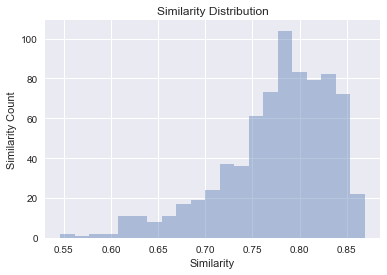

In [30]:
fig = sns.distplot(result.values, kde=False)
fig.set(xlabel='Similarity', ylabel='Similarity Count', title='Similarity Distribution');

In [33]:
result_df = pd.DataFrame(result)

In [34]:
result_df = result_df.reset_index()
result_df.head()

,text,similarity
0,John Arnold on AM Eric Thode ENRON AM To John...,0.741090
1,John Arnold on AM From Jason R Williams ENRON...,0.808377
2,John Arnold on AM From Margaret Allen ENRON o...,0.782976
3,John Arnold on AM Mark Sagel msagel homecom o...,0.719160
4,John Arnold on AM Matthew Arnold AM To John A...,0.746134


In [35]:
final = result_df.sort_values(by='similarity')

The most unique email by least average similarity across all documents:

In [36]:
final.iloc[0].text

'options Either we leave from work and you watch me get a haircut for minutes or I pick you up around'

In [37]:
final.iloc[0].similarity

0.54628971954874261

### Conclusion and Further Work
Using SpaCy makes document comparison very easy.  Using this to find outliers in text could be used in the field of CyberSecurity to compare users to themselves.  Once you compare users to themselves, you would have a baseline of thier language, and finding outliers to their baseline could also be of interest.  A very unique and also very negative text could be an indicator that a user is disgruntled. 

#### Discussion
The similarity score of 54.6% is still relatively high.  It doesn't give a very unique value (very low in comparison to each other).  There could be several reasons for this:
* Too much noise
* Bias in the average
* Comparison of the population to the entire population

There are several things that could help and would be included in future work:
* Removing the noise, cleaning up the text more
* Choosing a different average metric.  Instead of similarity against the entire population, maybe a max similarity score could be used by summing them for each email
* Finally, working with the same information but instead of comparing each email to the entire population, compare emails on a per user basis
